In [13]:
from __future__ import print_function, division, absolute_import
import os,sys
import numpy as np
from scipy.linalg import inv, block_diag
import time
from joblib import Parallel, delayed
import gudhi
sys.path.insert(0, "C:\\Users\\matt\\Desktop\\orbithunter\\")
from orbithunter import *
from mpl_toolkits.mplot3d.axes3d import *
import matplotlib.pyplot as plt
import itertools
from gudhi.hera import wasserstein_distance, bottleneck_distance
import glob

In [14]:
orbit_list = []
for orbit_h5 in glob.glob('../data/local/continuation/merge_tile_coarse/*.h5'):
    orbit_list.append(read_h5('../'+orbit_h5))

In [15]:
orbit1 = read_h5('RelativeOrbitKS_L13p093_T9p100.h5', directory='../data/local/continuation/merge_tile/')
orbit2 =  read_h5('RelativeOrbitKS_L12p997_T22p702.h5', directory='../data/local/continuation/merge_tile/')

In [16]:
pcc1 = orbit_periodic_cubical_complex(orbit1)
pcc2 = orbit_periodic_cubical_complex(orbit2)

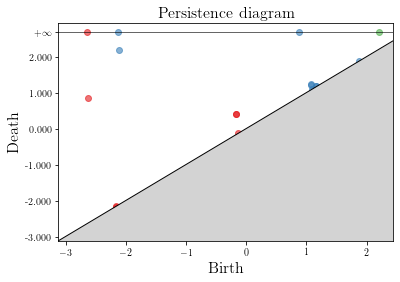

In [17]:
gudhi_plot(pcc1.persistence())

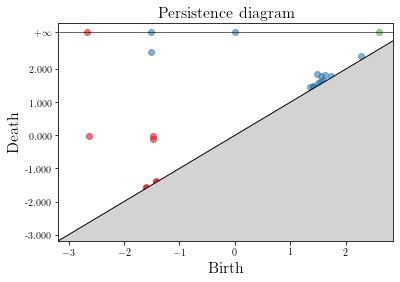

In [18]:
gudhi_plot(pcc2.persistence())

In [19]:
wd_list = []
for orbit1, orbit2 in np.array(list(itertools.product(orbit_list, orbit_list))):
    wd_list.append(gudhi_distance(orbit1, orbit2, metric='wasserstein_distance'))

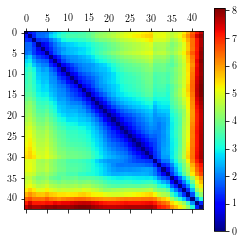

In [20]:
plt.matshow(np.reshape(wd_list, (int(np.sqrt(len(wd_list))), -1)), cmap='jet')
plt.colorbar()
plt.show()

In [21]:
wd_list_bd = []
for orbit1, orbit2 in np.array(list(itertools.product(orbit_list, orbit_list))):
    wd_list_bd.append(gudhi_distance(orbit1, orbit2, metric='bottleneck_distance'))

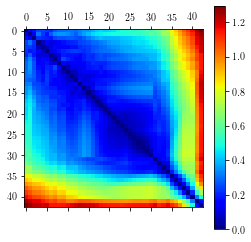

In [22]:
plt.matshow(np.reshape(wd_list_bd, (int(np.sqrt(len(wd_list))), -1)), cmap='jet')
plt.colorbar()
plt.show()

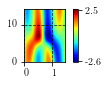

In [31]:
orbit_list[35].plot()

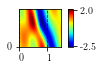

In [32]:
orbit_list[4].plot()

In [23]:
wd_list_hbd = []
for orbit1, orbit2 in np.array(list(itertools.product(orbit_list, orbit_list))):
    wd_list_hbd.append(gudhi_distance(orbit1, orbit2, metric='hera_bottleneck_distance'))

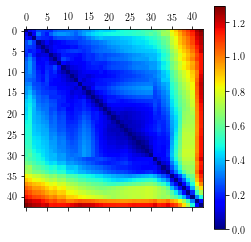

In [24]:
plt.matshow(np.reshape(wd_list_hbd, (int(np.sqrt(len(wd_list))), -1)), cmap='jet')
plt.colorbar()
plt.show()